In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

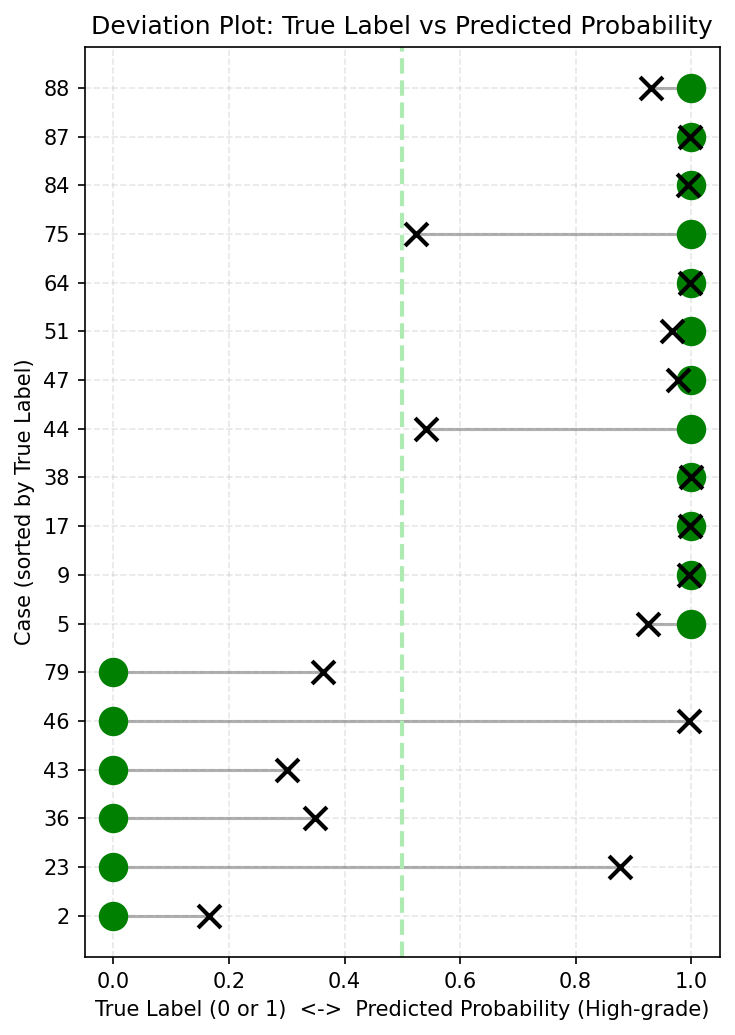

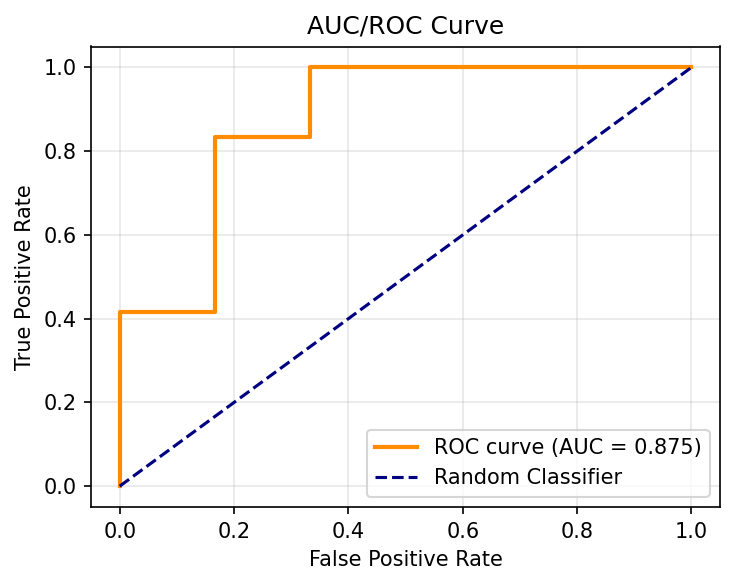


Computed AUC = 0.875


In [2]:
# =====================================================
# Combined Visualization Script
# - Green-dot deviation plot
# - AUC/ROC curve
# =====================================================


# -----------------------------------------------------
# Load predictions
# -----------------------------------------------------
df = pd.read_csv("/projects/e32998/MIL_training/pres_4_runs/run_20251116_111031/predictions.csv")

# Sort so true=0 cases appear first (optional but cleaner)
df_sorted = df.sort_values(["true_label", "case_id"]).reset_index(drop=True)
df_sorted["case_str"] = df_sorted["case_id"].astype(str)

# -----------------------------------------------------
# 1. Deviation Plot (True vs Probabilities)
# -----------------------------------------------------
plt.figure(figsize=(5,7), dpi=150)

for i, row in df_sorted.iterrows():
    # connecting line
    plt.plot(
        [row["true_label"], row["prob_high_grade"]],
        [i, i],
        color="gray",
        alpha=0.6,
        linewidth=1.5
    )

    # true label = large green circle
    plt.scatter(
        row["true_label"], i,
        color="green",
        s=200,
        marker="o",
        edgecolor="black",
        linewidth=0,
        zorder=3
    )

    # predicted probability = small black X
    plt.scatter(
        row["prob_high_grade"], i,
        color="black",
        s=120,
        marker="x",
        linewidths=2,
        zorder=4
    )

plt.yticks(range(len(df_sorted)), df_sorted["case_str"])
plt.axvline(0.5, color="#ADEBB3", linestyle="--", linewidth=2, label="Decision Threshold (0.5)")
plt.xlabel("True Label (0 or 1)  <->  Predicted Probability (High-grade)")
plt.ylabel("Case (sorted by True Label)")
plt.title("Deviation Plot: True Label vs Predicted Probability")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 2. AUC / ROC Curve
# -----------------------------------------------------
fpr, tpr, thresholds = roc_curve(df["true_label"], df["prob_high_grade"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4), dpi=150)
plt.plot(
    fpr, tpr,
    color='darkorange',
    lw=2,
    label=f'ROC curve (AUC = {roc_auc:.3f})'
)
plt.plot(
    [0, 1], [0, 1],
    color='navy',
    lw=1.5,
    linestyle='--',
    label='Random Classifier'
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC/ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nComputed AUC = {roc_auc:.3f}")

In [3]:
# read top % effective attention for each case
effattn = pd.read_csv("/projects/e32998/MIL_training/pres_4_runs/run_20251117_225617/attention_analysis/top_effective_patches_per_case_5.0pct.csv")

In [4]:
# Compute probability assigned to the true class
df_sorted["prob_true_class"] = df_sorted.apply(
    lambda row: row["prob_high_grade"] if row["true_label"] == 1 else row["prob_benign"],
    axis=1
)

df_sorted["gap"] = 1 - df_sorted["prob_true_class"]
# Absolute gap (same because gap ≥ 0, but you can keep this for clarity)
df_sorted["abs_gap"] = df_sorted["gap"].abs()


In [5]:
# Keep only the columns needed from df_sorted
df_gap = df_sorted[["case_id", "abs_gap"]]

# Merge into effattn
merged = effattn.merge(df_gap, on="case_id", how="left")


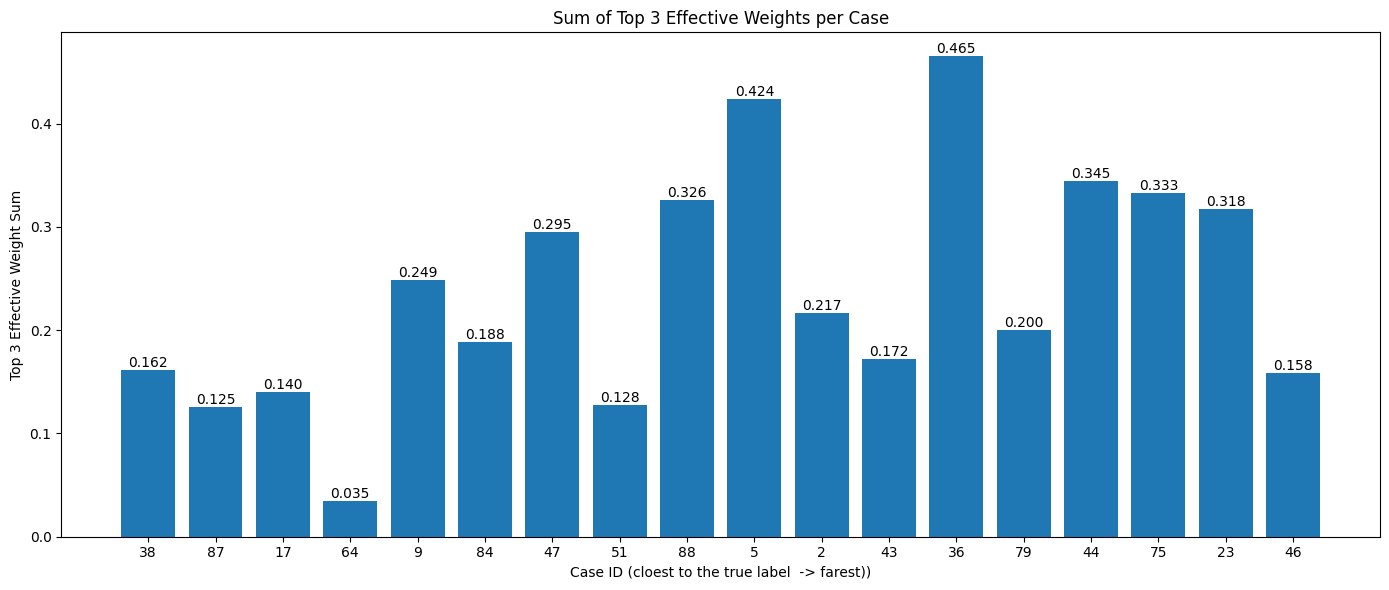

In [6]:
# Compute top-3 sum of effective weights per case
top3_sums = (
    merged.groupby("case_id")["effective_weight"]
          .apply(lambda x: x.nlargest(3).sum())
)

# Get abs_gap per case (unique per case_id)
gap_map = merged.groupby("case_id")["abs_gap"].first()

# Create a dataframe to sort properly
plot_df = pd.DataFrame({
    "top3_sum": top3_sums,
    "abs_gap": gap_map
})

# Sort by abs_gap ascending
plot_df = plot_df.sort_values("abs_gap", ascending=True)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(plot_df.index.astype(str), plot_df["top3_sum"].values)

plt.title("Sum of Top 3 Effective Weights per Case")
plt.xlabel("Case ID (cloest to the true label  -> farest))")
plt.ylabel("Top 3 Effective Weight Sum")

# Add numeric labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks()
plt.tight_layout()
plt.show()


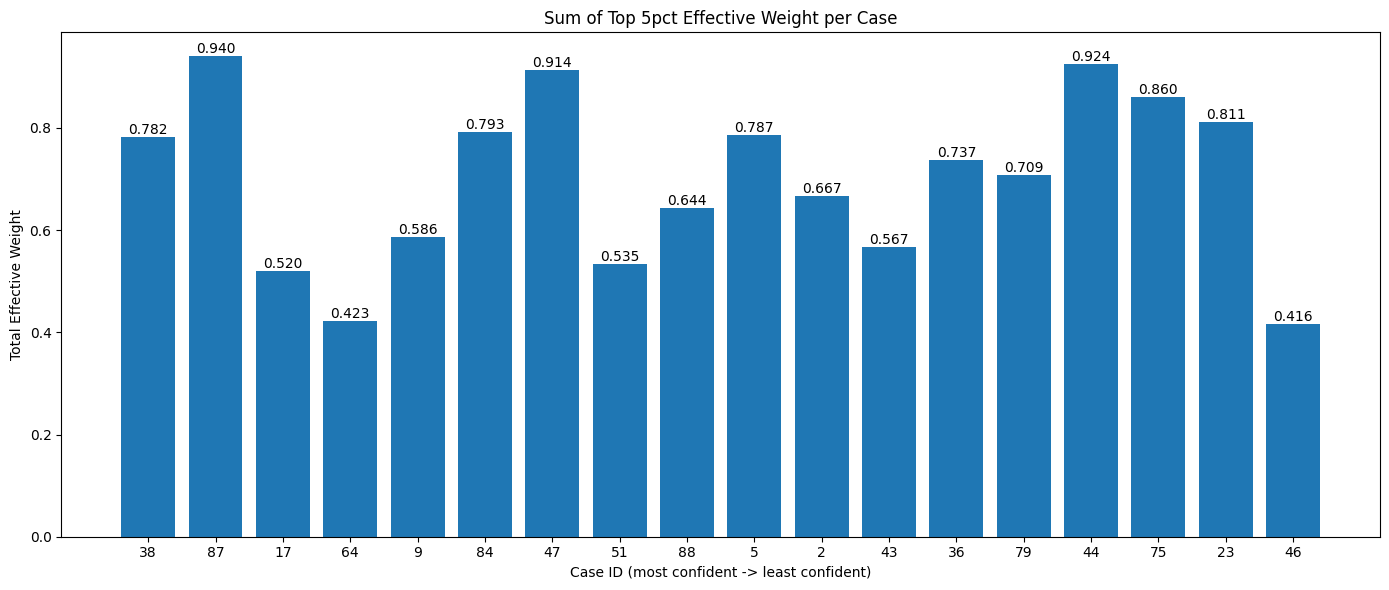

In [7]:
# Sum of effective weights per case
case_sums = merged.groupby("case_id")["effective_weight"].sum()

# Grab abs_gap per case (unique for each case_id)
gap_map = merged.groupby("case_id")["abs_gap"].first()

# Combine into a single dataframe for proper sorting
plot_df = pd.DataFrame({
    "total_sum": case_sums,
    "abs_gap": gap_map
})

# Sort by abs_gap ascending
plot_df = plot_df.sort_values("abs_gap", ascending=True)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(plot_df.index.astype(str), plot_df["total_sum"].values)

plt.title("Sum of Top 5pct Effective Weight per Case")
plt.xlabel("Case ID (most confident -> least confident)")
plt.ylabel("Total Effective Weight")

# Add numeric labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks()
plt.tight_layout()
plt.show()


In [8]:

results = []

for case_id, subdf in merged.groupby("case_id"):
    corr_patch = subdf["patch_attn_weight"].corr(subdf["effective_weight"])
    corr_slice = subdf["slice_attn_weight"].corr(subdf["effective_weight"])
    corr_stain = subdf["stain_attn_weight"].corr(subdf["effective_weight"])

    results.append({
        "case_id": case_id,
        "corr_patch_effective": corr_patch,
        "corr_slice_effective": corr_slice,
        "corr_stain_effective": corr_stain
    })

results_df = pd.DataFrame(results)

# Also compute global correlations across all patches
global_corr = {
    "global_corr_patch": merged["patch_attn_weight"].corr(merged["effective_weight"]),
    "global_corr_slice": merged["slice_attn_weight"].(merged["effective_weight"]),
    "global_corr_stain": merged["stain_attn_weight"].corr(merged["effective_weight"]),
}


SyntaxError: invalid syntax (313703169.py, line 20)

In [20]:
results_df

,case_id,corr_patch_effective,corr_slice_effective,corr_stain_effective
0,2,0.643378,0.366981,-0.329489
1,5,0.992530,-0.131125,0.192653
2,9,0.858694,0.146011,-0.222804
3,17,0.988573,0.573206,-0.566621
4,23,0.929260,0.226459,-0.155491
5,36,0.830339,0.294385,-0.109299
6,38,0.766112,0.166811,-0.157211
7,43,0.996889,NaN,-0.054214
8,44,0.882688,0.226921,-0.084194
9,46,0.539926,NaN,-0.253011


In [21]:
global_corr

{'global_corr_patch': np.float64(0.8024418962788656),
 'global_corr_slice': np.float64(0.2605721470978075),
 'global_corr_stain': np.float64(-0.06700569459005921)}

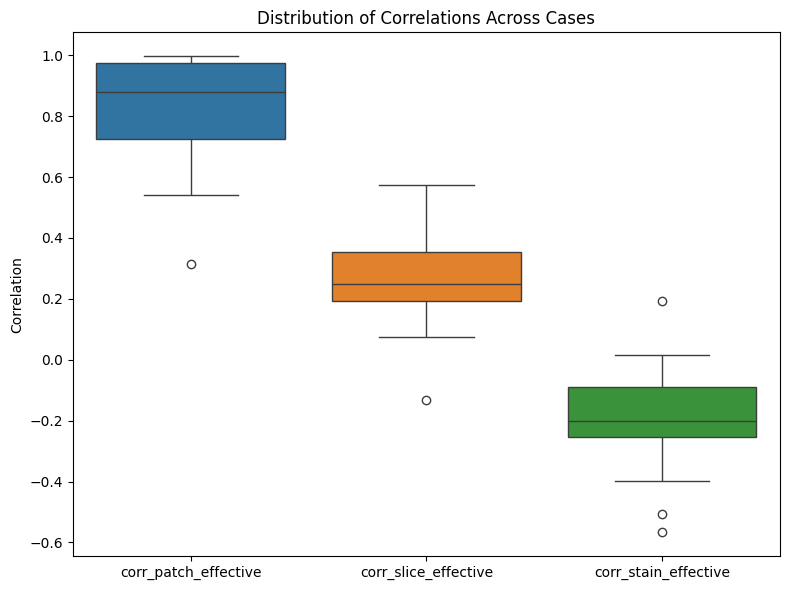

In [25]:
# visualize correlation between attention layers and effective attention

plt.figure(figsize=(8,6))
sns.boxplot(data=results_df.drop(columns="case_id"))
plt.title("Distribution of Correlations Across Cases")
plt.ylabel("Correlation")
plt.xticks()
plt.tight_layout()
plt.show()


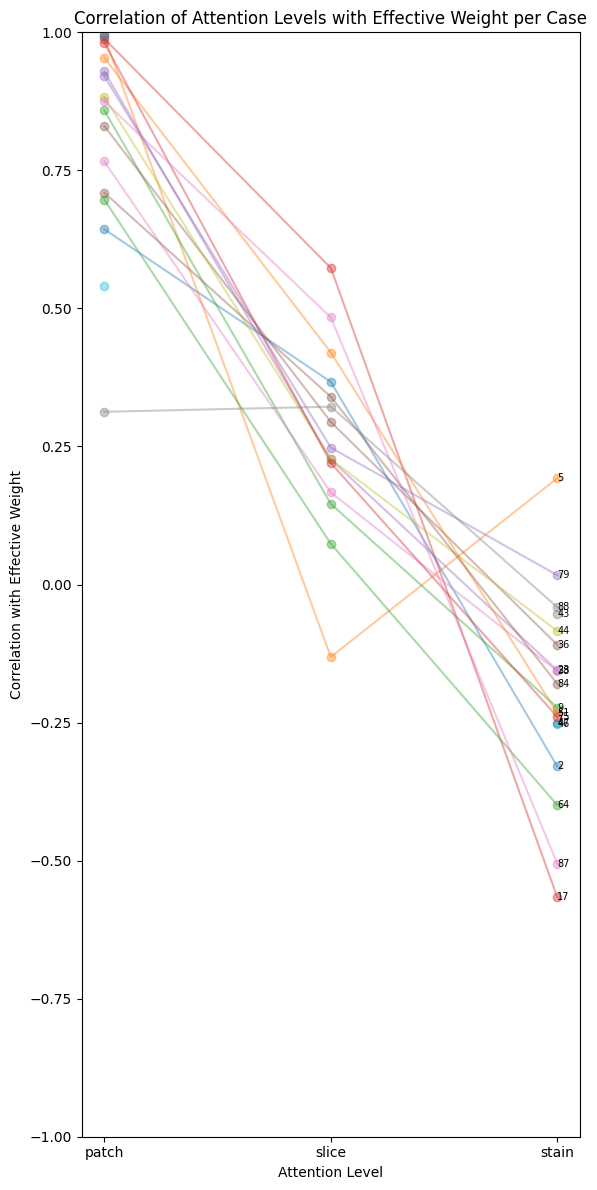

In [31]:
plot_df = results_df.melt(
    id_vars=["case_id"],
    value_vars=[
        "corr_patch_effective",
        "corr_slice_effective",
        "corr_stain_effective"
    ],
    var_name="attn_level",
    value_name="correlation"
)

# rename for nicer x-axis labels
plot_df["attn_level"] = plot_df["attn_level"].map({
    "corr_patch_effective": "patch",
    "corr_slice_effective": "slice",
    "corr_stain_effective": "stain"
})

plt.figure(figsize=(6, 12))

# Plot each case as a separate line
for case_id, subdf in plot_df.groupby("case_id"):
    plt.plot(
        subdf["attn_level"],
        subdf["correlation"],
        marker="o",
        alpha=0.4
    )

    # ADD LABEL AT LAST POINT OF THE LINE (ONLY NEW THING)
    x_last = subdf["attn_level"].iloc[-1]
    y_last = subdf["correlation"].iloc[-1]
    plt.text(
        x_last,
        y_last,
        str(case_id),
        fontsize=7,
        va="center",
        ha="left"
    )

plt.ylim(-1, 1)
plt.xlabel("Attention Level")
plt.ylabel("Correlation with Effective Weight")
plt.title("Correlation of Attention Levels with Effective Weight per Case")

plt.tight_layout()
plt.show()

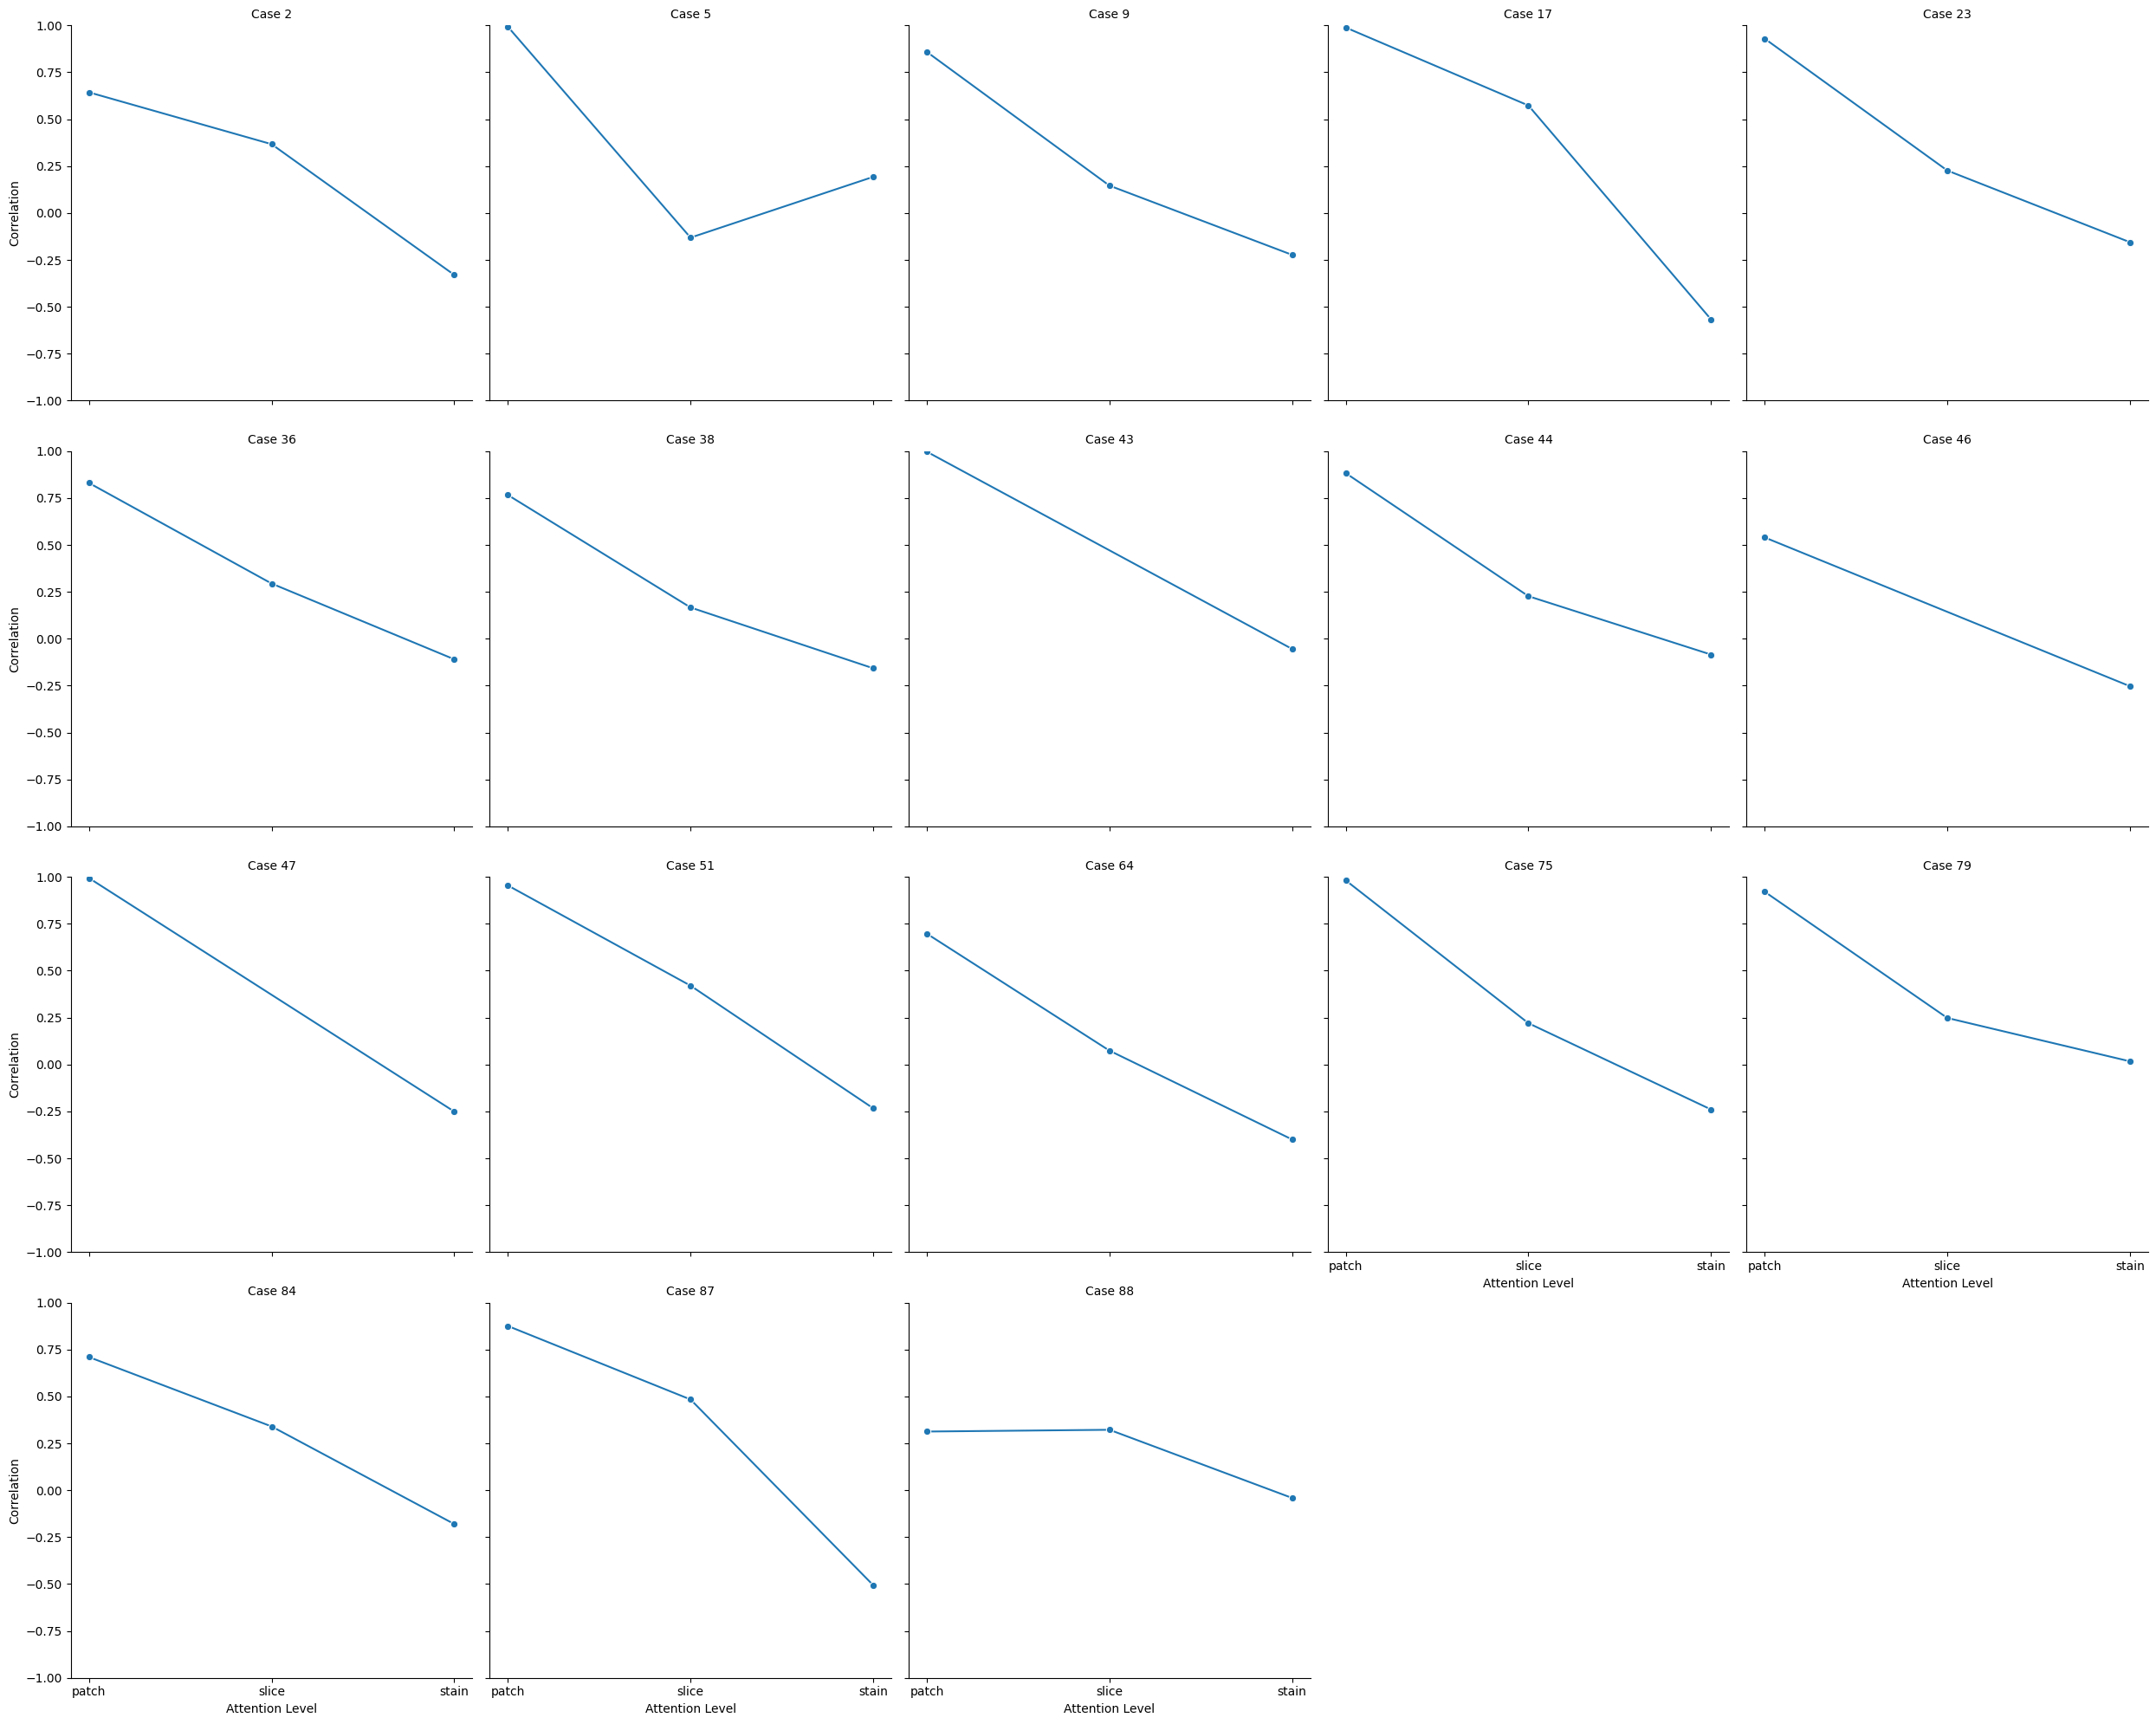

In [32]:


# starting from your `plot_df`
g = sns.relplot(
    data=plot_df,
    x="attn_level",
    y="correlation",
    col="case_id",         # facet by case_id
    col_wrap=5,            # adjust depending on how many you want per row
    kind="line",
    marker="o",
    facet_kws={'sharey': True, 'sharex': True}
)

g.set_titles("Case {col_name}")
g.set_axis_labels("Attention Level", "Correlation")

plt.ylim(-1, 1)
plt.tight_layout()
plt.show()


In [25]:
plot_df

,total_sum,abs_gap
case_id,,
38,0.782049,0.000785
87,0.940005,0.001120
17,0.520107,0.002193
64,0.422979,0.002549
9,0.586477,0.003760
84,0.792564,0.006143
47,0.913856,0.021871
51,0.534616,0.033320
88,0.643642,0.068846


<Axes: xlabel='abs_gap', ylabel='total_sum'>

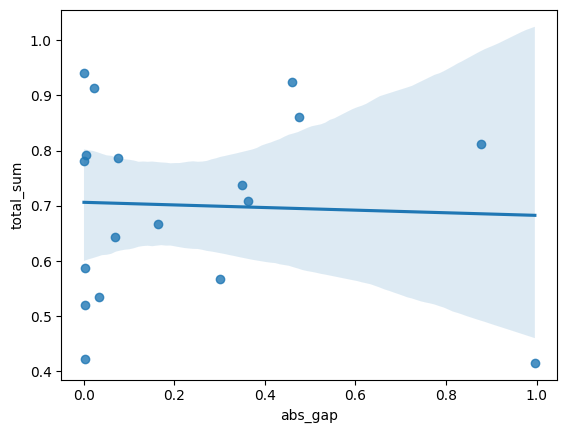

In [26]:
sns.regplot(data=plot_df, x='abs_gap', y='total_sum')

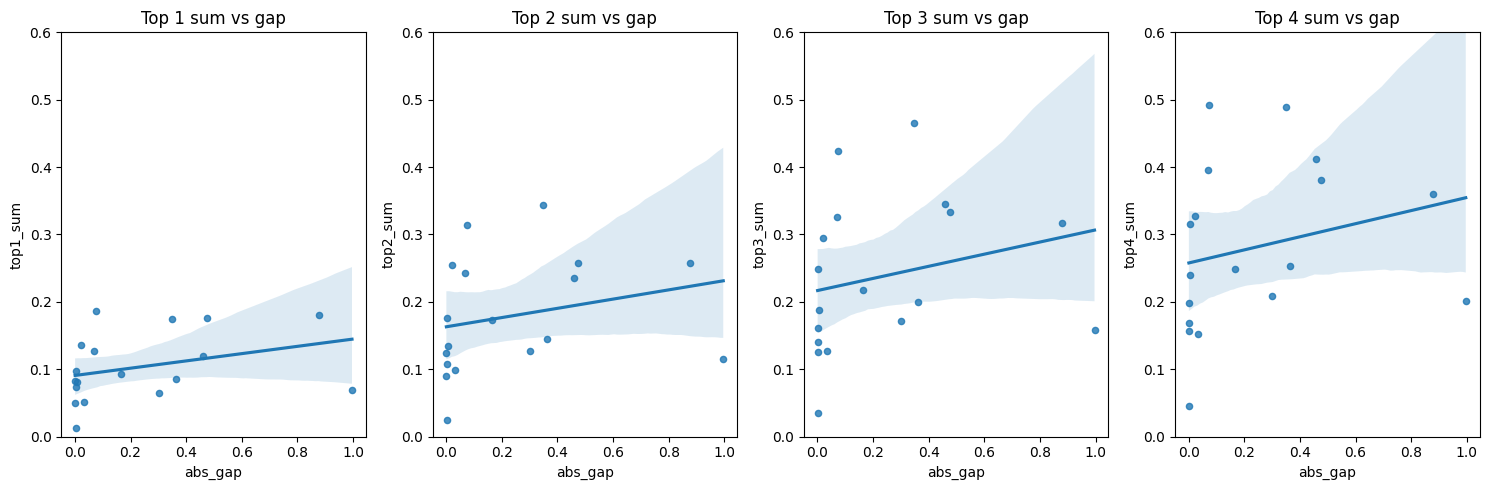

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 4 columns

for k in range(1,5):
    topk_sums = (
        merged.groupby("case_id")["effective_weight"]
              .apply(lambda x: x.nlargest(k).sum())
    )

    # abs_gap is constant per case
    gap_map = merged.groupby("case_id")["abs_gap"].first()

    # Merge into dataframe
    plot_df = pd.DataFrame({
        "topk_sum": topk_sums,
        "abs_gap": gap_map
    })

    sns.regplot(
        data=plot_df,
        x='abs_gap',
        y='topk_sum',
        ax=axes[k-1],
        scatter_kws={'s': 20}
    )

    axes[k-1].set_title(f"Top {k} sum vs gap")
    axes[k-1].set_xlabel("abs_gap")
    axes[k-1].set_ylabel(f"top{k}_sum")
    axes[k-1].set_ylim((0,0.6))

plt.tight_layout()
plt.show()

In [20]:
case_numpatch = effattn.groupby('case_id').count()[['patch_idx']].reset_index().rename(columns={'patch_idx': 'num_patches'})


In [22]:
plot2=case_numpatch.merge(plot_df, on='case_id')

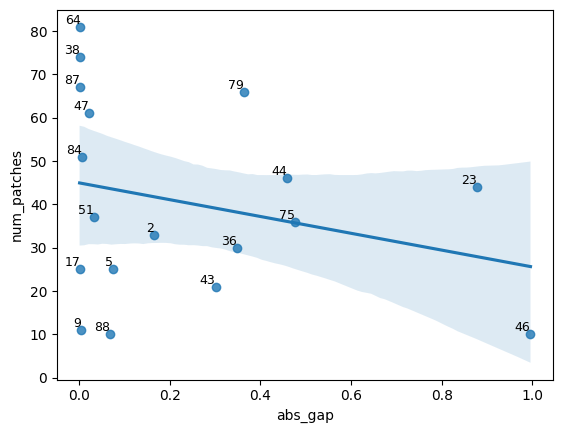

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=plot2['abs_gap'], y=plot2['num_patches'])

for i, row in plot2.iterrows():
    plt.text(row['abs_gap'], row['num_patches'], str(int(row['case_id'])),  # convert to int
             fontsize=9,
             ha='right',
             va='bottom')

plt.show()
